In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [37]:
# 1. Data Loading and Initial Exploration
print("Step 1: Loading and Exploring Data")
print("-" * 50)
# Load the data
df = pd.read_csv('historic_demand_2009_2024.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())


Step 1: Loading and Exploring Data
--------------------------------------------------
Dataset shape: (279264, 24)

First 5 rows:
   Unnamed: 0 settlement_date  settlement_period     nd    tsd  \
0           0      2009-01-01                  1  37910  38704   
1           1      2009-01-01                  2  38047  38964   
2           2      2009-01-01                  3  37380  38651   
3           3      2009-01-01                  4  36426  37775   
4           4      2009-01-01                  5  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded

In [38]:
# 2. Data Preprocessing
print("\nStep 2: Data Preprocessing")
print("-" * 50)
# Convert settlement_date to datetime
df['settlement_date'] = pd.to_datetime(df['settlement_date'])

# Extract date features
df['year'] = df['settlement_date'].dt.year
df['month'] = df['settlement_date'].dt.month
df['day'] = df['settlement_date'].dt.day
df['dayofweek'] = df['settlement_date'].dt.dayofweek
df['quarter'] = df['settlement_date'].dt.quarter
df['season'] = df['month'] % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Fall

# Create hour from settlement_period (48 settlement periods per day)
df['hour'] = (df['settlement_period'] - 1) // 2
df['half_hour'] = (df['settlement_period'] - 1) % 2

# Create peak/off-peak feature (considering 7am-11pm as peak hours)
df['is_peak'] = ((df['hour'] >= 7) & (df['hour'] < 23)).astype(int)

# Create weekend feature
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Fill missing values
print("\nFilling missing values...")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        # Fill with median for numeric columns
        df[col].fillna(df[col].median(), inplace=True)

# Handle potential outliers in the main target column
Q1 = df['england_wales_demand'].quantile(0.25)
Q3 = df['england_wales_demand'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nPotential outliers in england_wales_demand: {((df['england_wales_demand'] < lower_bound) | (df['england_wales_demand'] > upper_bound)).sum()}")


Step 2: Data Preprocessing
--------------------------------------------------

Filling missing values...

Potential outliers in england_wales_demand: 214



Step 3: Exploratory Data Analysis
--------------------------------------------------

Generating time series plot of demand...


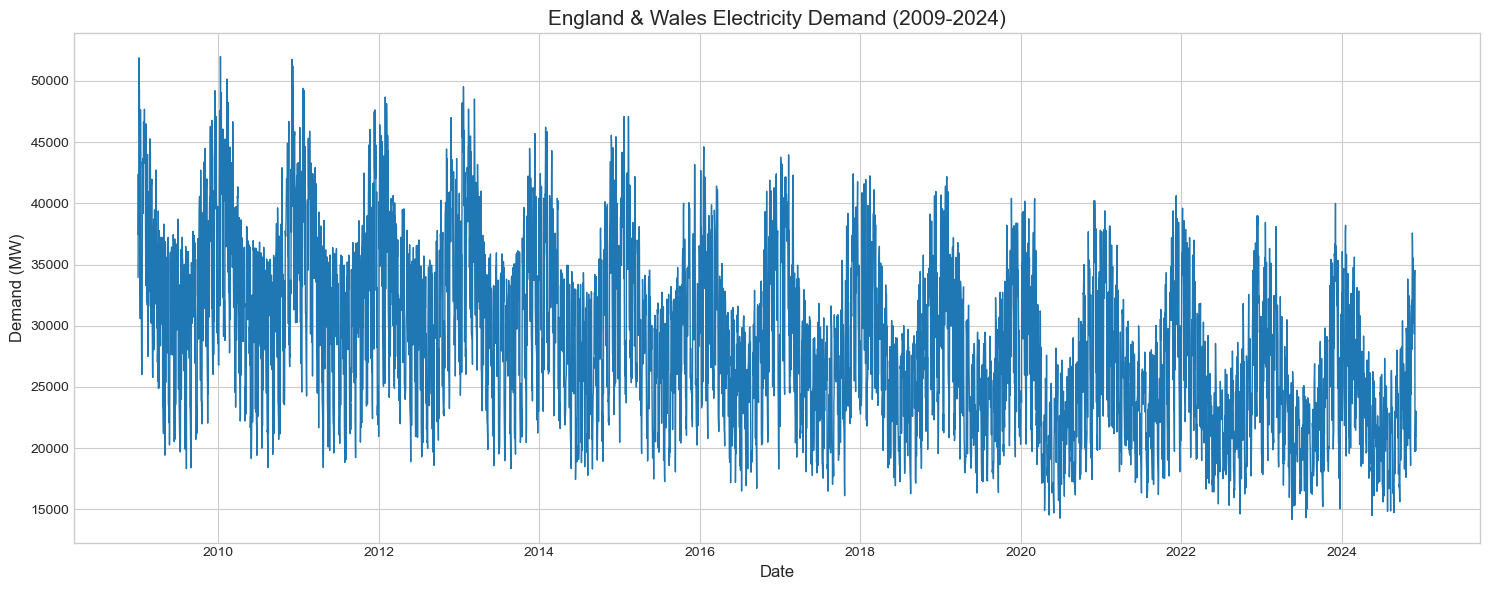


Generating monthly demand patterns...


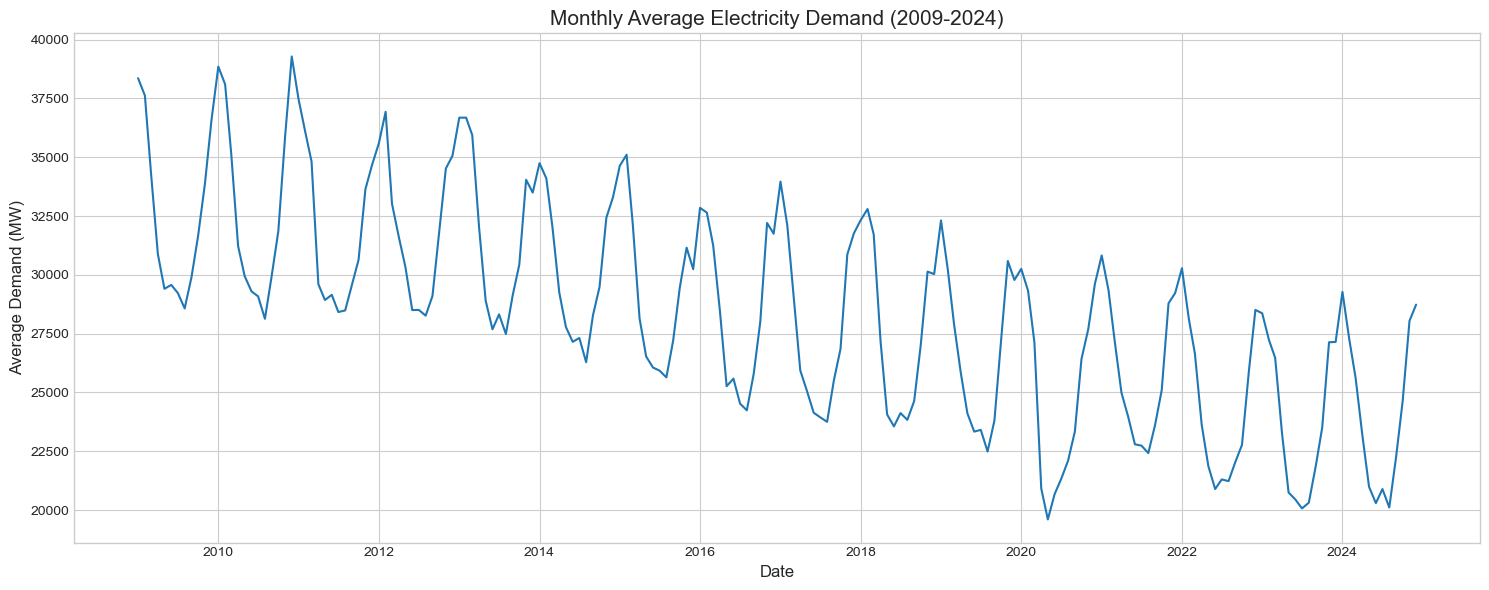


Generating seasonal patterns...


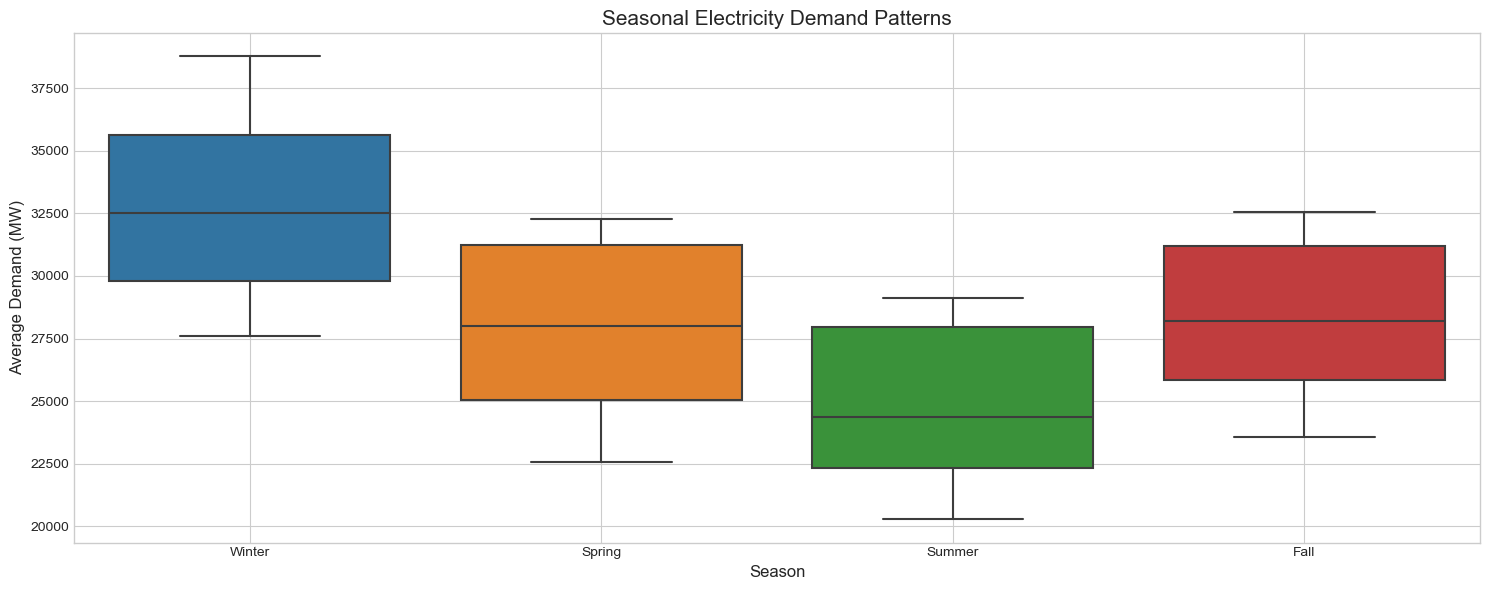


Generating daily demand patterns...


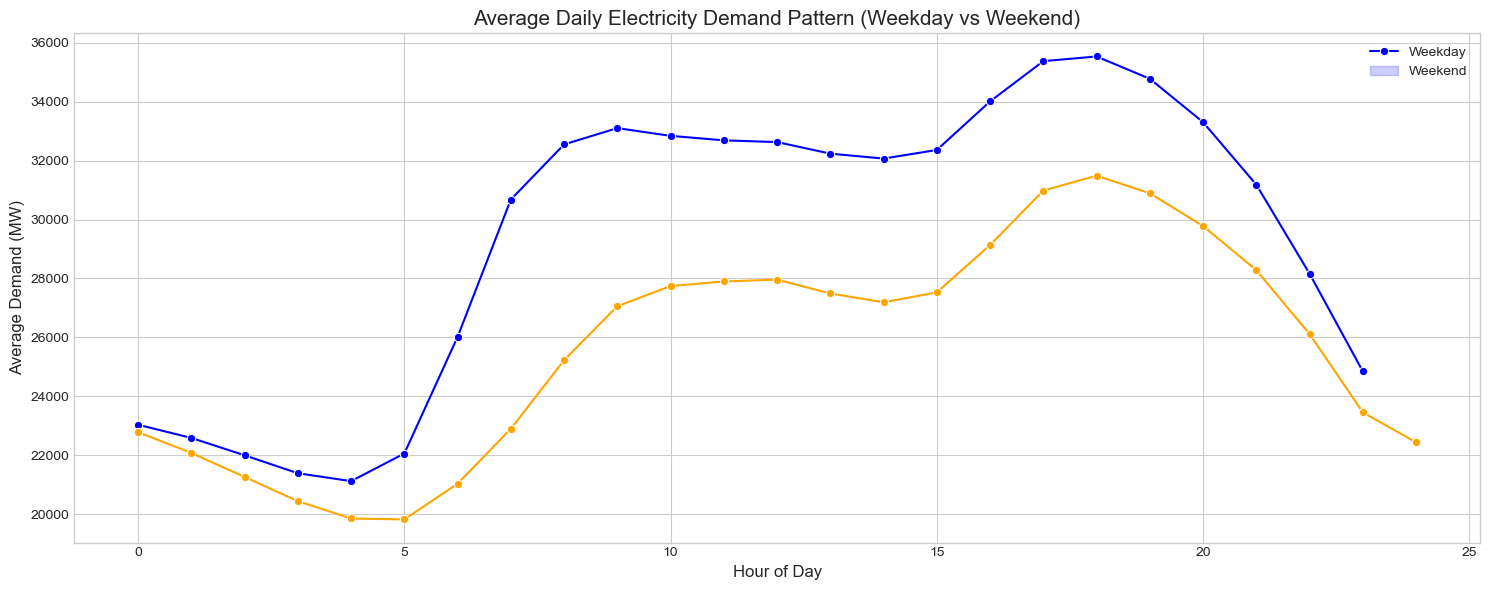


Examining holiday impact...


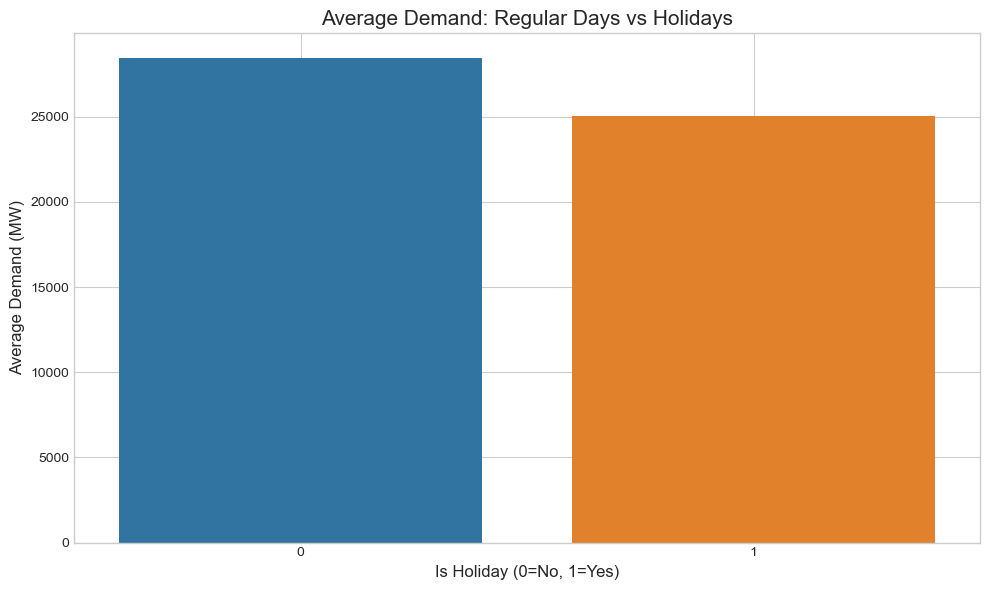

In [39]:
# 3. Exploratory Data Analysis
print("\nStep 3: Exploratory Data Analysis")
print("-" * 50)

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

# Plot 1: Time series of demand
print("\nGenerating time series plot of demand...")
plt.figure(figsize=(15, 6))
# Sample data for better visibility
sample_df = df.sort_values('settlement_date').iloc[::50]  # Take every 50th row
plt.plot(sample_df['settlement_date'], sample_df['england_wales_demand'], linewidth=1)
plt.title('England & Wales Electricity Demand (2009-2024)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Monthly aggregated demand
print("\nGenerating monthly demand patterns...")
monthly_demand = df.groupby(['year', 'month'])['england_wales_demand'].mean().reset_index()
monthly_demand['date'] = pd.to_datetime(monthly_demand[['year', 'month']].assign(day=1))
plt.figure(figsize=(15, 6))
plt.plot(monthly_demand['date'], monthly_demand['england_wales_demand'])
plt.title('Monthly Average Electricity Demand (2009-2024)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Seasonal patterns
print("\nGenerating seasonal patterns...")
season_demand = df.groupby(['year', 'season'])['england_wales_demand'].mean().reset_index()
season_labels = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
season_demand['season_name'] = season_demand['season'].map(season_labels)

plt.figure(figsize=(15, 6))
sns.boxplot(x='season_name', y='england_wales_demand', data=season_demand)
plt.title('Seasonal Electricity Demand Patterns', fontsize=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 4: Daily patterns
print("\nGenerating daily demand patterns...")
hourly_demand = df.groupby(['hour', 'is_weekend'])['england_wales_demand'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(x='hour', y='england_wales_demand', hue='is_weekend', 
             data=hourly_demand, marker='o', 
             palette=['blue', 'orange'])
plt.title('Average Daily Electricity Demand Pattern (Weekday vs Weekend)', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 5: Holiday impact
print("\nExamining holiday impact...")
holiday_comparison = df.groupby('is_holiday')['england_wales_demand'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='is_holiday', y='england_wales_demand', data=holiday_comparison)
plt.title('Average Demand: Regular Days vs Holidays', fontsize=15)
plt.xlabel('Is Holiday (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# 4. Feature Engineering for Modeling
print("\nStep 4: Feature Engineering")
print("-" * 50)

# Create features for modeling
print("Creating modeling features...")
# Select relevant columns for modeling
modeling_features = ['settlement_period', 'hour', 'half_hour', 'is_peak', 
                    'day', 'month', 'year', 'dayofweek', 'is_weekend', 
                    'is_holiday', 'season', 'quarter',
                    'embedded_wind_generation', 'embedded_wind_capacity',
                    'embedded_solar_generation', 'embedded_solar_capacity']

# Add interconnector flows if available
interconnectors = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 
                  'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow',
                  'viking_flow', 'greenlink_flow']

for ic in interconnectors:
    if ic in df.columns:
        modeling_features.append(ic)

# Create lagged features (previous day, previous week)
# Same hour previous day
df['demand_previous_day'] = df.groupby(['hour'])['england_wales_demand'].shift(48)  # 48 half-hours = 1 day
# Same hour previous week
df['demand_previous_week'] = df.groupby(['hour'])['england_wales_demand'].shift(48*7)  # 48*7 half-hours = 1 week

# Add moving averages
df['demand_rolling_24h'] = df['england_wales_demand'].rolling(window=48).mean()  # 48 half-hours = 24 hours
df['demand_rolling_7d'] = df['england_wales_demand'].rolling(window=48*7).mean()  # 48*7 half-hours = 7 days

# Add to features
modeling_features.extend(['demand_previous_day', 'demand_previous_week', 
                         'demand_rolling_24h', 'demand_rolling_7d'])

# Prepare final modeling dataset
print("\nPreparing final modeling dataset...")
X = df[modeling_features].copy()
y = df['england_wales_demand'].copy()

# Handle missing values in features
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)


Step 4: Feature Engineering
--------------------------------------------------
Creating modeling features...

Preparing final modeling dataset...



Step 5: Clustering Analysis
--------------------------------------------------
Performing clustering analysis...


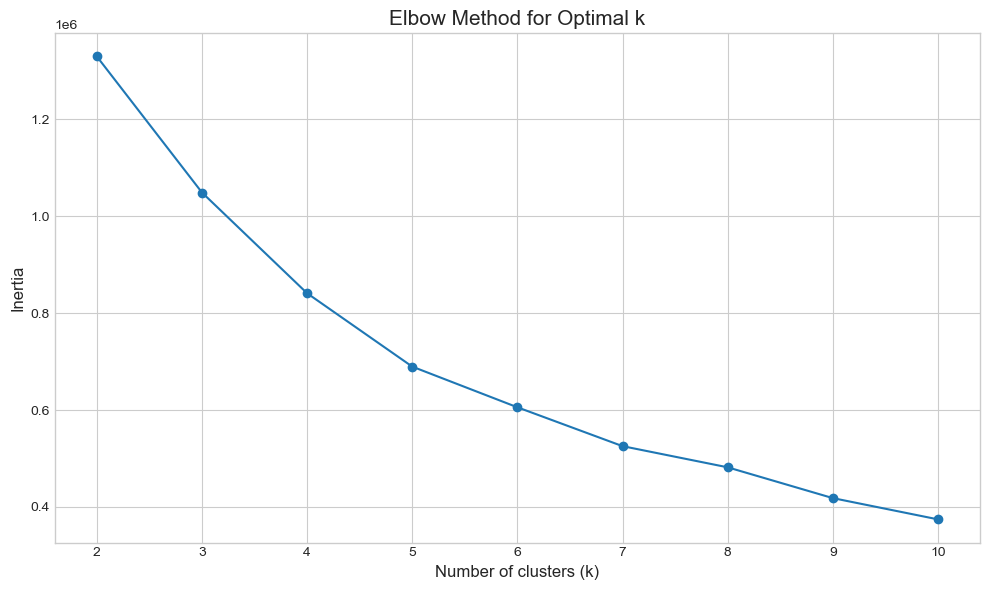


Cluster analysis:
  cluster england_wales_demand                                  hour  \
                          mean          std    min    max       mean   
0       0         31186.496069  5611.691536  16411  53325  15.791300   
1       1         21438.747603  3252.136083      0  35858   4.707656   
2       2         32299.924730  6254.149515  15984  52921  13.380913   
3       3         25036.821724  5548.111893  13107  46368  11.500000   

  is_weekend is_holiday     month    season  
        mean       mean      mean      mean  
0   0.224241        0.0  9.194480  3.184242  
1   0.402907        0.0  7.374392  2.828909  
2   0.256812        0.0  2.708082  1.509263  
3   0.038168        1.0  6.251908  1.816794  


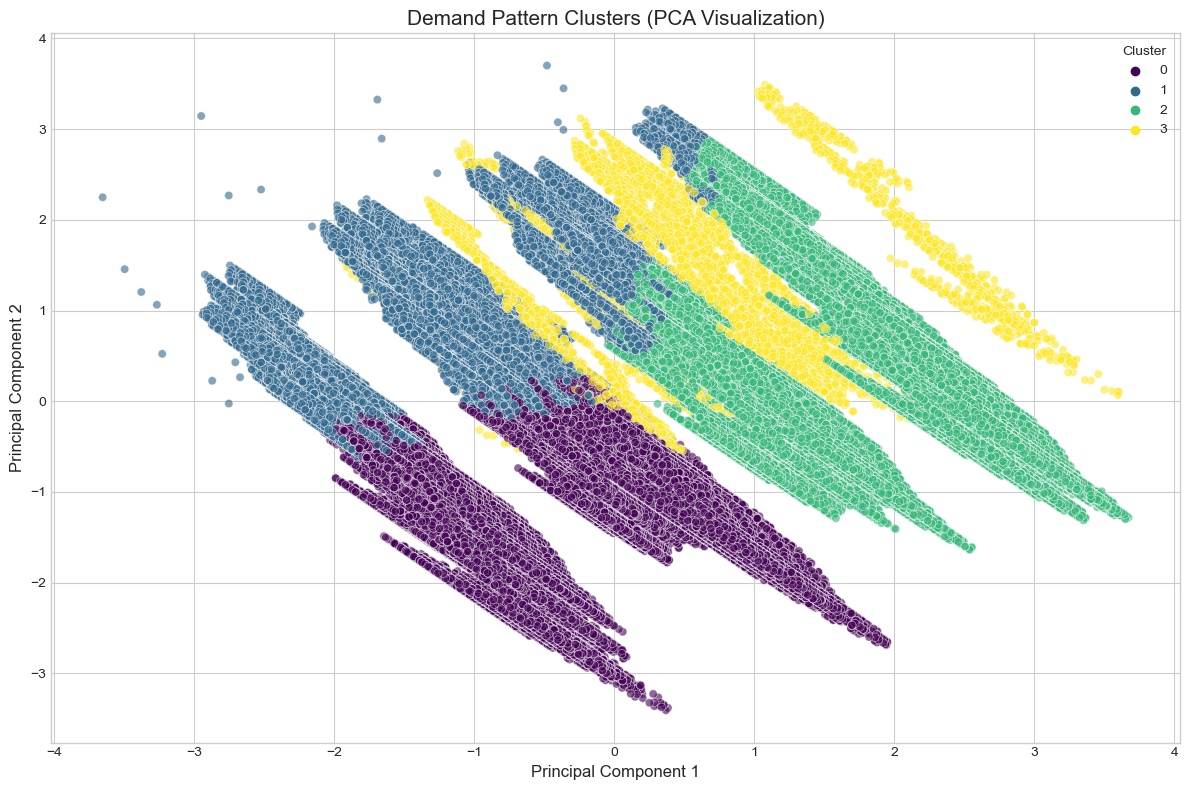

In [41]:
# 5. Clustering Analysis
print("\nStep 5: Clustering Analysis")
print("-" * 50)

# Select features for clustering
print("Performing clustering analysis...")
cluster_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'season', 'england_wales_demand']
cluster_df = df[cluster_features].dropna()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=15)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply K-means with optimal k (assuming k=4 based on typical demand patterns)
optimal_k = 4  # This would be determined from elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)
cluster_df['cluster'] = cluster_labels

# Analyze clusters
print("\nCluster analysis:")
cluster_summary = cluster_df.groupby('cluster').agg({
    'england_wales_demand': ['mean', 'std', 'min', 'max'],
    'hour': 'mean',
    'is_weekend': 'mean',
    'is_holiday': 'mean',
    'month': 'mean',
    'season': 'mean'
}).reset_index()
print(cluster_summary)

# Visualize clusters with PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
cluster_df['pca1'] = pca_result[:, 0]
cluster_df['pca2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=cluster_df, palette='viridis', alpha=0.6)
plt.title('Demand Pattern Clusters (PCA Visualization)', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# 6. Predictive Modeling Setup
print("\nStep 6: Predictive Modeling Setup")
print("-" * 50)

# Remove rows with NaN due to lagged features
print("Preparing train/test split...")
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Create training and testing datasets (using time-based split)
# Use the last 3 months for testing
split_date = df['settlement_date'].max() - pd.Timedelta(days=90)
train_mask = df['settlement_date'] < split_date
test_mask = df['settlement_date'] >= split_date

X_train = X[train_mask & mask].copy()
X_test = X[test_mask & mask].copy()
y_train = y[train_mask & mask].copy()
y_test = y[test_mask & mask].copy()

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)



Step 6: Predictive Modeling Setup
--------------------------------------------------
Preparing train/test split...
Training set size: (274894, 30)
Testing set size: (4370, 30)



Step 7: Model 1 - Linear Regression
--------------------------------------------------
Training Linear Regression model...

Performing cross-validation for Linear Regression...
Cross-validation RMSE scores: [4751.45007822 2111.97540279 2142.67580525 2309.43774873 1968.0920736 ]
Mean CV RMSE: 2656.73, Std Dev: 1052.97

Evaluating Linear Regression on test set...
Test RMSE: 2059.14
Test MAE: 1609.13
Test R²: 0.8543


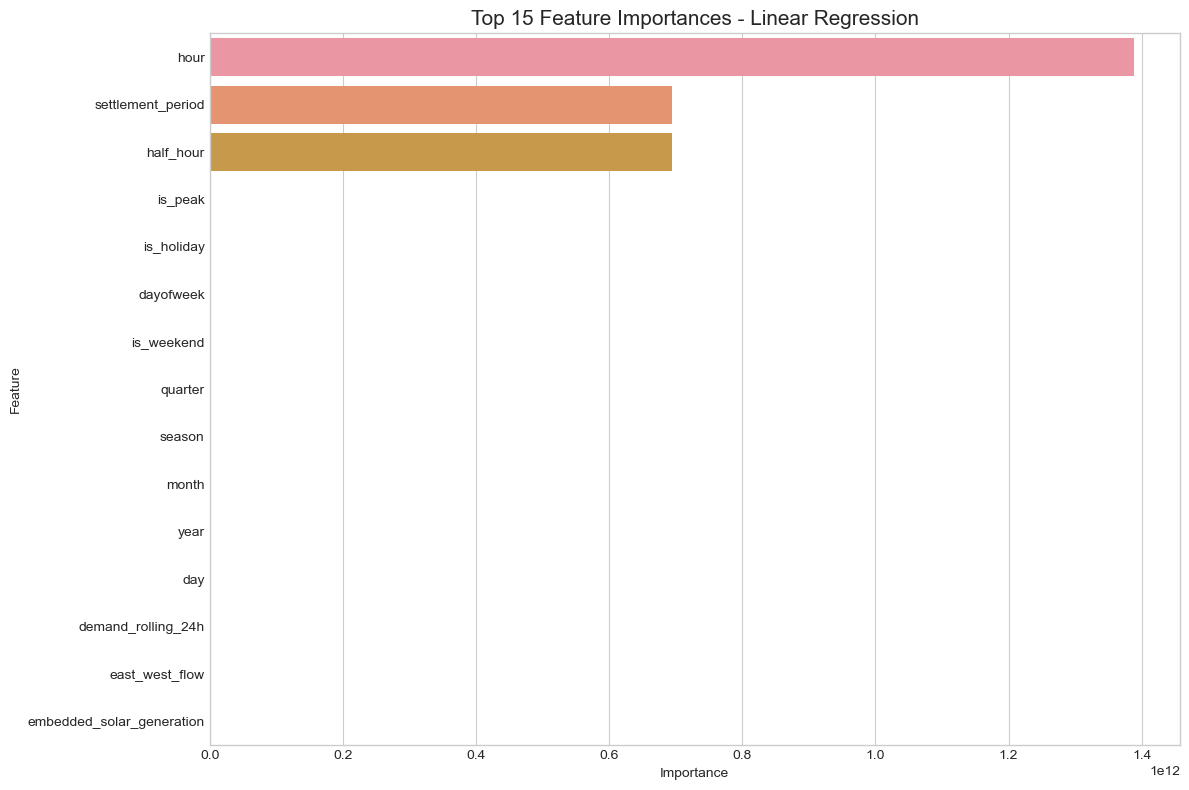

In [43]:
# 7. Model 1: Linear Regression
print("\nStep 7: Model 1 - Linear Regression")
print("-" * 50)

# Train Linear Regression model
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Cross-validation for Linear Regression
print("\nPerforming cross-validation for Linear Regression...")
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
lr_cv_rmse = np.sqrt(-lr_cv_scores)
print(f"Cross-validation RMSE scores: {lr_cv_rmse}")
print(f"Mean CV RMSE: {lr_cv_rmse.mean():.2f}, Std Dev: {lr_cv_rmse.std():.2f}")

# Model evaluation on test set
print("\nEvaluating Linear Regression on test set...")
lr_preds = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

print(f"Test RMSE: {lr_rmse:.2f}")
print(f"Test MAE: {lr_mae:.2f}")
print(f"Test R²: {lr_r2:.4f}")

# Feature importance for Linear Regression
lr_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(lr_model.coef_)
})
lr_importance = lr_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=lr_importance.head(15))
plt.title('Top 15 Feature Importances - Linear Regression', fontsize=15)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


Generating monthly demand patterns...


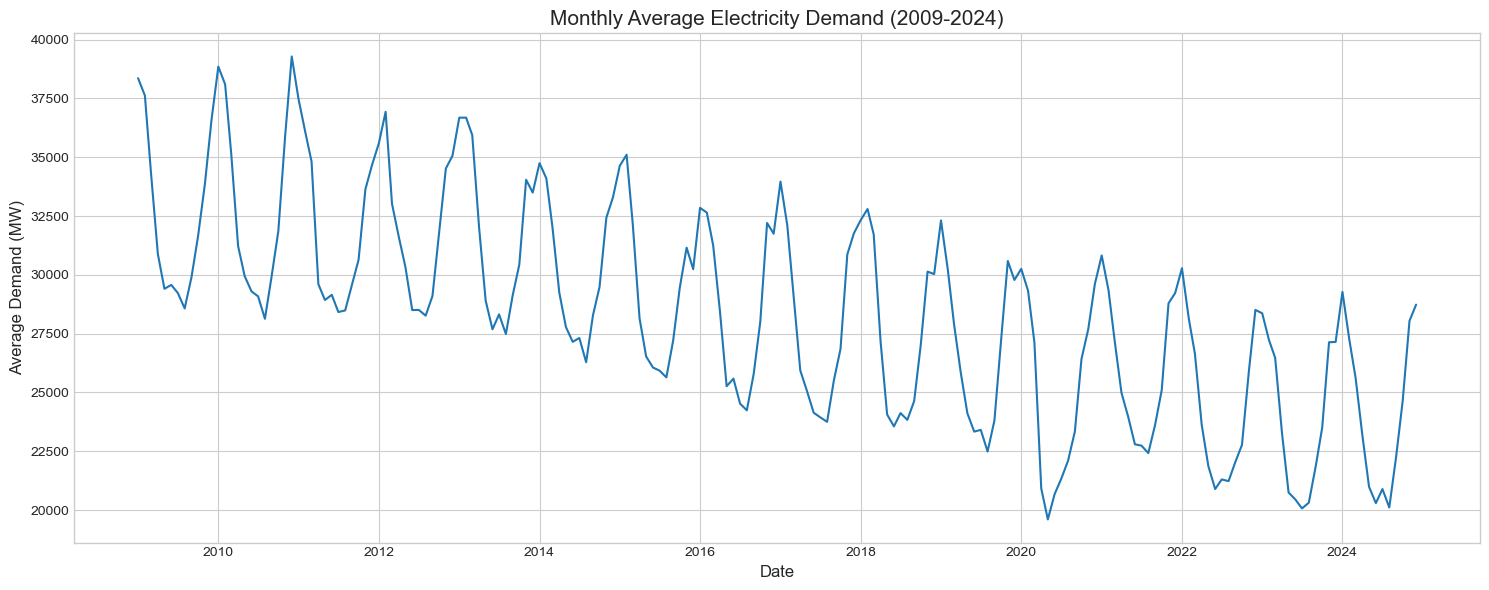

In [28]:
# Plot 2: Monthly aggregated demand
print("\nGenerating monthly demand patterns...")
monthly_demand = df.groupby(['year', 'month'])['england_wales_demand'].mean().reset_index()
monthly_demand['date'] = pd.to_datetime(monthly_demand[['year', 'month']].assign(day=1))
plt.figure(figsize=(15, 6))
plt.plot(monthly_demand['date'], monthly_demand['england_wales_demand'])
plt.title('Monthly Average Electricity Demand (2009-2024)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Generating seasonal patterns...


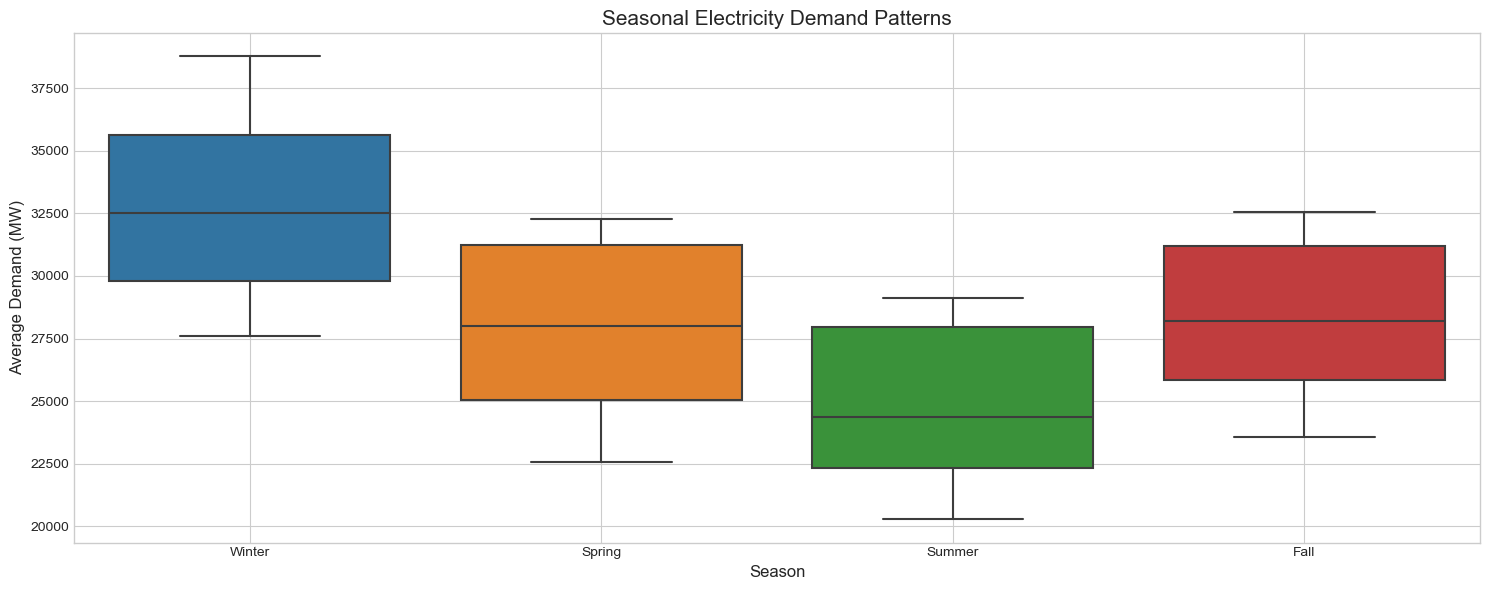

In [29]:
# Plot 3: Seasonal patterns
print("\nGenerating seasonal patterns...")
season_demand = df.groupby(['year', 'season'])['england_wales_demand'].mean().reset_index()
season_labels = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
season_demand['season_name'] = season_demand['season'].map(season_labels)

plt.figure(figsize=(15, 6))
sns.boxplot(x='season_name', y='england_wales_demand', data=season_demand)
plt.title('Seasonal Electricity Demand Patterns', fontsize=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()



Generating daily demand patterns...


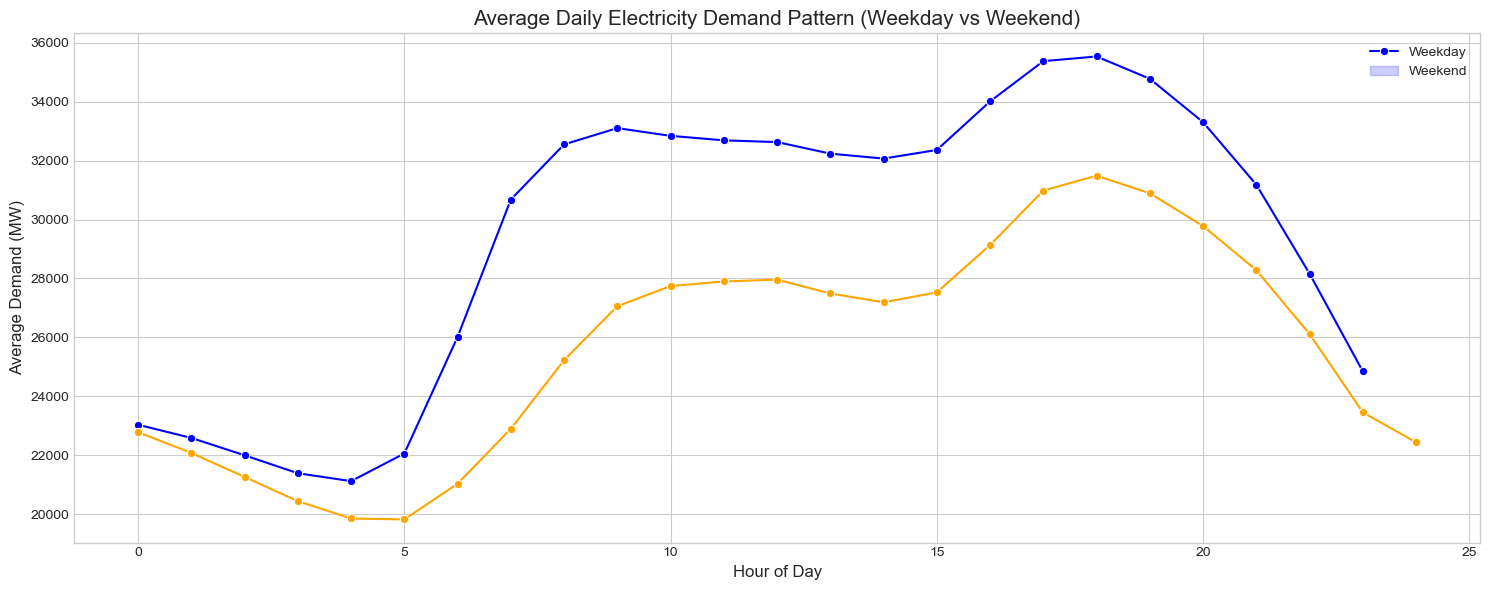

In [30]:
# Plot 4: Daily patterns
print("\nGenerating daily demand patterns...")
hourly_demand = df.groupby(['hour', 'is_weekend'])['england_wales_demand'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(x='hour', y='england_wales_demand', hue='is_weekend', 
             data=hourly_demand, marker='o', 
             palette=['blue', 'orange'])
plt.title('Average Daily Electricity Demand Pattern (Weekday vs Weekend)', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.tight_layout()
plt.show()



Examining holiday impact...


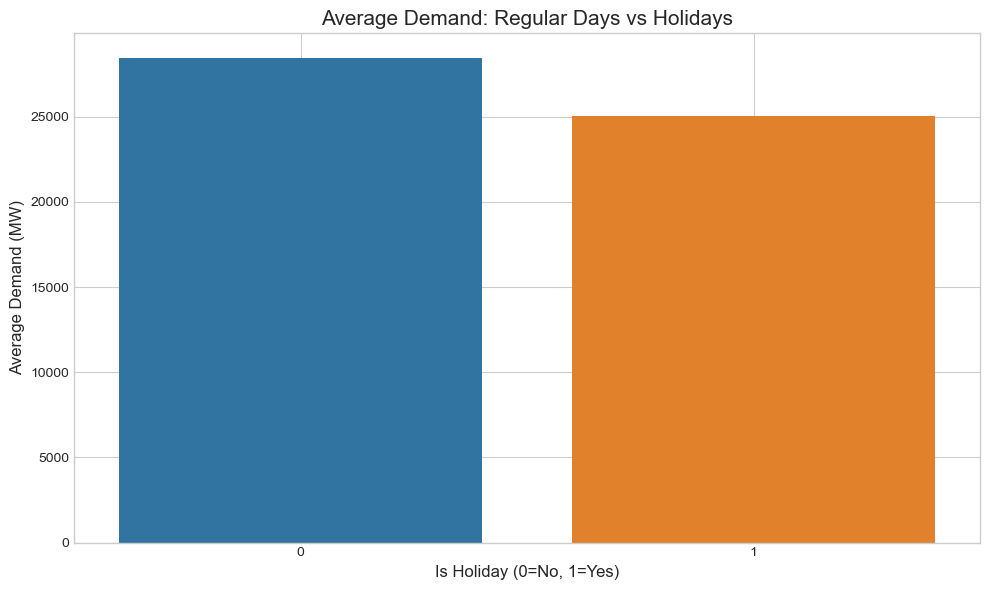

In [31]:
# Plot 5: Holiday impact
print("\nExamining holiday impact...")
holiday_comparison = df.groupby('is_holiday')['england_wales_demand'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='is_holiday', y='england_wales_demand', data=holiday_comparison)
plt.title('Average Demand: Regular Days vs Holidays', fontsize=15)
plt.xlabel('Is Holiday (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
print("\nStep 4: Feature Engineering")
print("-" * 50)


Step 4: Feature Engineering
--------------------------------------------------


In [33]:
print("Creating modeling features...")
# Select relevant columns for modeling
modeling_features = ['settlement_period', 'hour', 'half_hour', 'is_peak', 
                    'day', 'month', 'year', 'dayofweek', 'is_weekend', 
                    'is_holiday', 'season', 'quarter',
                    'embedded_wind_generation', 'embedded_wind_capacity',
                    'embedded_solar_generation', 'embedded_solar_capacity']

# Add interconnector flows if available
interconnectors = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 
                  'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow',
                  'viking_flow', 'greenlink_flow']

for ic in interconnectors:
    if ic in df.columns:
        modeling_features.append(ic)

# Create lagged features (previous day, previous week)
# Same hour previous day
df['demand_previous_day'] = df.groupby(['hour'])['england_wales_demand'].shift(48)  # 48 half-hours = 1 day
# Same hour previous week
df['demand_previous_week'] = df.groupby(['hour'])['england_wales_demand'].shift(48*7)  # 48*7 half-hours = 1 week

# Add moving averages
df['demand_rolling_24h'] = df['england_wales_demand'].rolling(window=48).mean()  # 48 half-hours = 24 hours
df['demand_rolling_7d'] = df['england_wales_demand'].rolling(window=48*7).mean()  # 48*7 half-hours = 7 days

# Add to features
modeling_features.extend(['demand_previous_day', 'demand_previous_week', 
                         'demand_rolling_24h', 'demand_rolling_7d'])

# Prepare final modeling dataset
print("\nPreparing final modeling dataset...")
X = df[modeling_features].copy()
y = df['england_wales_demand'].copy()

# Handle missing values in features
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

Creating modeling features...

Preparing final modeling dataset...


In [35]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title('Feature Importance')
plt.show()

NameError: name 'rf_model' is not defined


Step 5: Clustering Analysis
--------------------------------------------------
Performing clustering analysis...


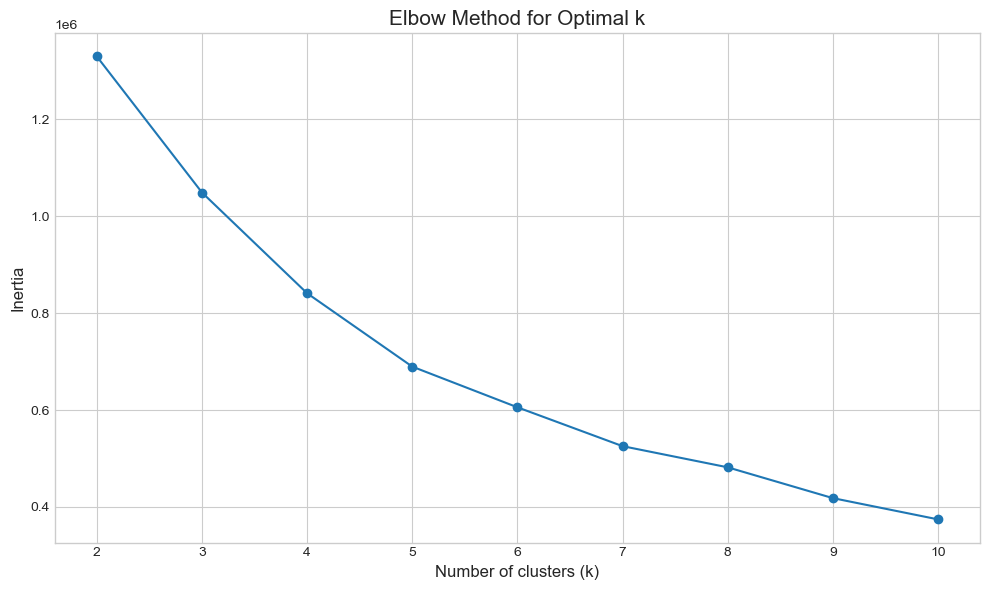


Cluster analysis:
  cluster england_wales_demand                                  hour  \
                          mean          std    min    max       mean   
0       0         31186.496069  5611.691536  16411  53325  15.791300   
1       1         21438.747603  3252.136083      0  35858   4.707656   
2       2         32299.924730  6254.149515  15984  52921  13.380913   
3       3         25036.821724  5548.111893  13107  46368  11.500000   

  is_weekend is_holiday     month    season  
        mean       mean      mean      mean  
0   0.224241        0.0  9.194480  3.184242  
1   0.402907        0.0  7.374392  2.828909  
2   0.256812        0.0  2.708082  1.509263  
3   0.038168        1.0  6.251908  1.816794  


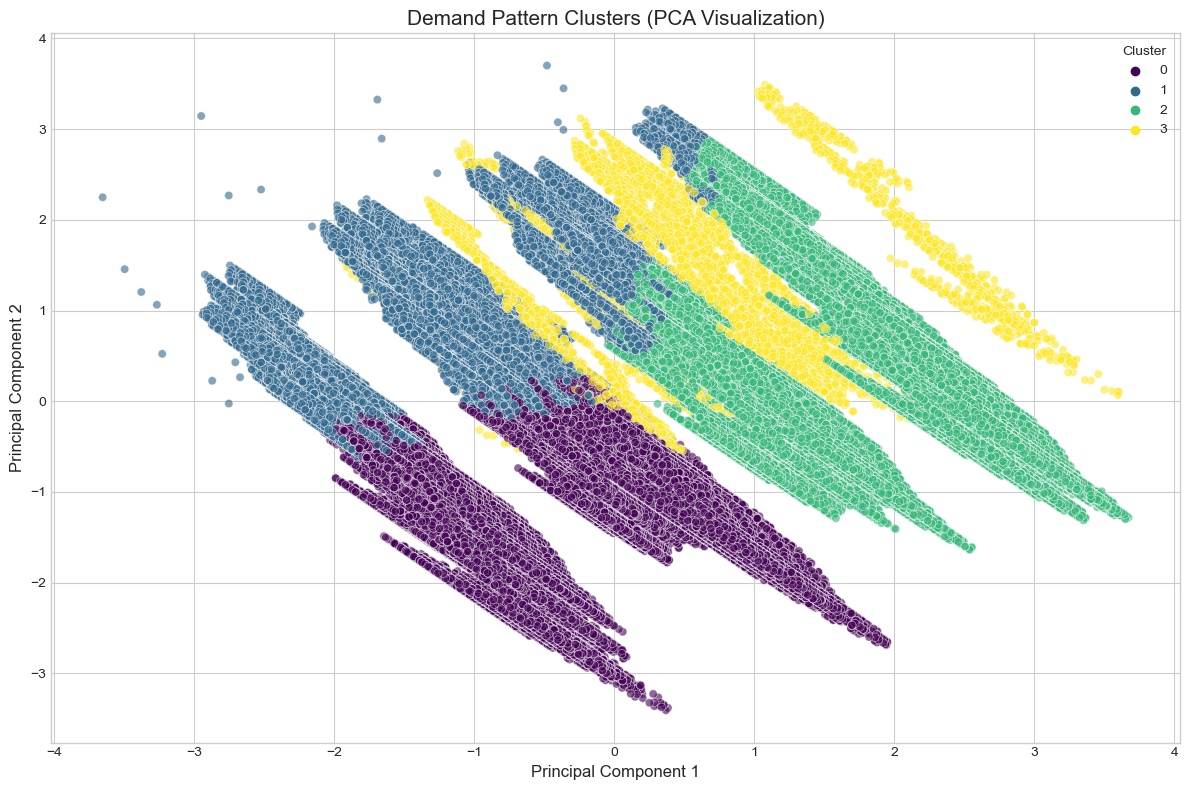

In [36]:
print("\nStep 5: Clustering Analysis")
print("-" * 50)

# Select features for clustering
print("Performing clustering analysis...")
cluster_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'season', 'england_wales_demand']
cluster_df = df[cluster_features].dropna()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=15)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply K-means with optimal k (assuming k=4 based on typical demand patterns)
optimal_k = 4  # This would be determined from elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)
cluster_df['cluster'] = cluster_labels

# Analyze clusters
print("\nCluster analysis:")
cluster_summary = cluster_df.groupby('cluster').agg({
    'england_wales_demand': ['mean', 'std', 'min', 'max'],
    'hour': 'mean',
    'is_weekend': 'mean',
    'is_holiday': 'mean',
    'month': 'mean',
    'season': 'mean'
}).reset_index()
print(cluster_summary)

# Visualize clusters with PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
cluster_df['pca1'] = pca_result[:, 0]
cluster_df['pca2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=cluster_df, palette='viridis', alpha=0.6)
plt.title('Demand Pattern Clusters (PCA Visualization)', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
# 6. Predictive Modeling Setup
print("\nStep 6: Predictive Modeling Setup")
print("-" * 50)

# Remove rows with NaN due to lagged features
print("Preparing train/test split...")
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Create training and testing datasets (using time-based split)
# Use the last 3 months for testing
split_date = df['settlement_date'].max() - pd.Timedelta(days=90)
train_mask = df['settlement_date'] < split_date
test_mask = df['settlement_date'] >= split_date

X_train = X[train_mask & mask].copy()
X_test = X[test_mask & mask].copy()
y_train = y[train_mask & mask].copy()
y_test = y[test_mask & mask].copy()

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 7. Model 1: Linear Regression
print("\nStep 7: Model 1 - Linear Regression")
print("-" * 50)

# Train Linear Regression model
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Cross-validation for Linear Regression
print("\nPerforming cross-validation for Linear Regression...")
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
lr_cv_rmse = np.sqrt(-lr_cv_scores)
print(f"Cross-validation RMSE scores: {lr_cv_rmse}")
print(f"Mean CV RMSE: {lr_cv_rmse.mean():.2f}, Std Dev: {lr_cv_rmse.std():.2f}")

# Model evaluation on test set
print("\nEvaluating Linear Regression on test set...")
lr_preds = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

print(f"Test RMSE: {lr_rmse:.2f}")
print(f"Test MAE: {lr_mae:.2f}")
print(f"Test R²: {lr_r2:.4f}")


Step 6: Predictive Modeling Setup
--------------------------------------------------
Preparing train/test split...
Training set size: (274894, 30)
Testing set size: (4370, 30)

Step 7: Model 1 - Linear Regression
--------------------------------------------------
Training Linear Regression model...

Performing cross-validation for Linear Regression...
Cross-validation RMSE scores: [4751.45007822 2111.97540279 2142.67580525 2309.43774873 1968.0920736 ]
Mean CV RMSE: 2656.73, Std Dev: 1052.97

Evaluating Linear Regression on test set...
Test RMSE: 2059.14
Test MAE: 1609.13
Test R²: 0.8543


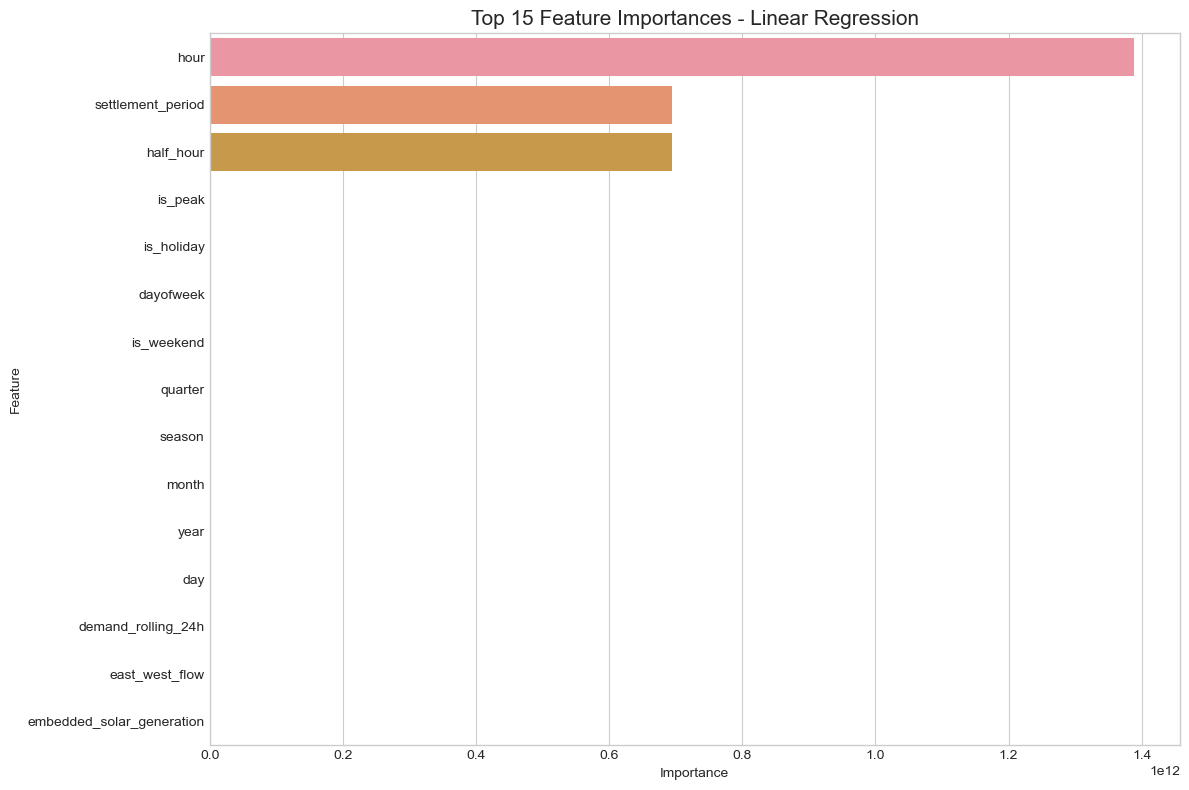

In [38]:
# Feature importance for Linear Regression
lr_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(lr_model.coef_)
})
lr_importance = lr_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=lr_importance.head(15))
plt.title('Top 15 Feature Importances - Linear Regression', fontsize=15)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


Step 8: Model 2 - Gradient Boosting Regressor
--------------------------------------------------
Training Gradient Boosting model...

Performing cross-validation for Gradient Boosting...
Cross-validation RMSE scores: [1097.68494535 2366.06875521 1120.80267378 1260.35279497 1052.00703061]
Mean CV RMSE: 1379.38, Std Dev: 498.22

Evaluating Gradient Boosting on test set...
Test RMSE: 1024.24
Test MAE: 788.62
Test R²: 0.9640


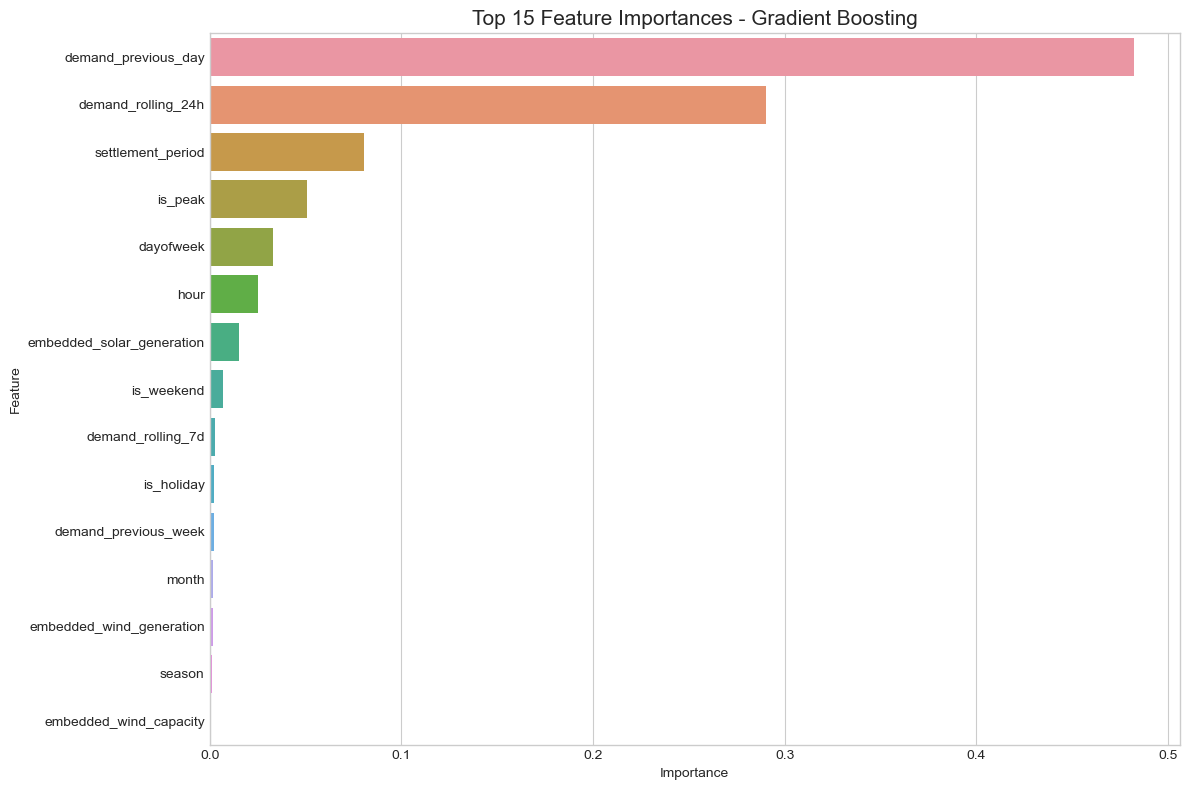

In [44]:
# 8. Model 2: Gradient Boosting Regressor
print("\nStep 8: Model 2 - Gradient Boosting Regressor")
print("-" * 50)

# Train Gradient Boosting model
print("Training Gradient Boosting model...")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Cross-validation for Gradient Boosting
print("\nPerforming cross-validation for Gradient Boosting...")
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
gb_cv_rmse = np.sqrt(-gb_cv_scores)
print(f"Cross-validation RMSE scores: {gb_cv_rmse}")
print(f"Mean CV RMSE: {gb_cv_rmse.mean():.2f}, Std Dev: {gb_cv_rmse.std():.2f}")

# Model evaluation on test set
print("\nEvaluating Gradient Boosting on test set...")
gb_preds = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))
gb_mae = mean_absolute_error(y_test, gb_preds)
gb_r2 = r2_score(y_test, gb_preds)

print(f"Test RMSE: {gb_rmse:.2f}")
print(f"Test MAE: {gb_mae:.2f}")
print(f"Test R²: {gb_r2:.4f}")

# Feature importance for Gradient Boosting
gb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
})
gb_importance = gb_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=gb_importance.head(15))
plt.title('Top 15 Feature Importances - Gradient Boosting', fontsize=15)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [45]:
# 9. Model 3: Support Vector Regression
print("\nStep 9: Model 3 - Support Vector Regression")
print("-" * 50)

# For SVR, we'll use a sample of the training data to make computation faster
# SVR can be slow on large datasets
sample_size = min(10000, len(X_train))
random_indices = np.random.choice(X_train.index, size=sample_size, replace=False)
X_train_sample = X_train.loc[random_indices]
y_train_sample = y_train.loc[random_indices]

# Scale the data for SVR (important for performance)
scaler_svr = StandardScaler()
X_train_scaled = scaler_svr.fit_transform(X_train_sample)
X_test_scaled = scaler_svr.transform(X_test)

# Train SVR model
print("Training Support Vector Regression model...")
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
svr_model.fit(X_train_scaled, y_train_sample)

# Model evaluation on test set
print("\nEvaluating SVR on test set...")
svr_preds = svr_model.predict(X_test_scaled)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_preds))
svr_mae = mean_absolute_error(y_test, svr_preds)
svr_r2 = r2_score(y_test, svr_preds)

print(f"Test RMSE: {svr_rmse:.2f}")
print(f"Test MAE: {svr_mae:.2f}")
print(f"Test R²: {svr_r2:.4f}")


Step 9: Model 3 - Support Vector Regression
--------------------------------------------------
Training Support Vector Regression model...

Evaluating SVR on test set...
Test RMSE: 3975.87
Test MAE: 3260.05
Test R²: 0.4569



Step 10: Model Comparison
--------------------------------------------------

Model Performance Comparison:
               Model         RMSE          MAE        R²
0  Linear Regression  2059.142893  1609.126234  0.854334
1  Gradient Boosting  1024.236852   788.624992  0.963960
2                SVR  3975.873832  3260.052751  0.456939


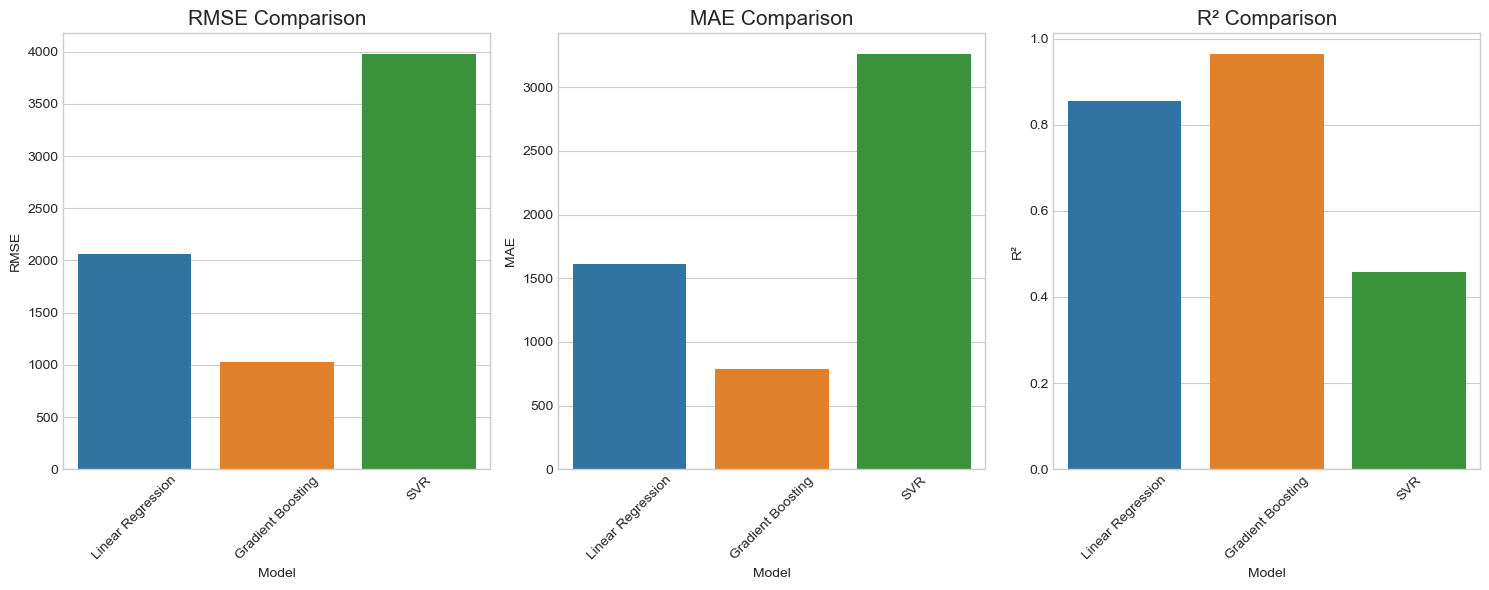

In [46]:
# 10. Model Comparison
print("\nStep 10: Model Comparison")
print("-" * 50)

# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Gradient Boosting', 'SVR'],
    'RMSE': [lr_rmse, gb_rmse, svr_rmse],
    'MAE': [lr_mae, gb_mae, svr_mae],
    'R²': [lr_r2, gb_r2, svr_r2]
})

print("\nModel Performance Comparison:")
print(model_comparison)

# Plot comparison
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='RMSE', data=model_comparison)
plt.title('RMSE Comparison', fontsize=15)
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='MAE', data=model_comparison)
plt.title('MAE Comparison', fontsize=15)
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='R²', data=model_comparison)
plt.title('R² Comparison', fontsize=15)
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()



Step 11: Visualize Predictions for Best Model
--------------------------------------------------
Best performing model: Gradient Boosting


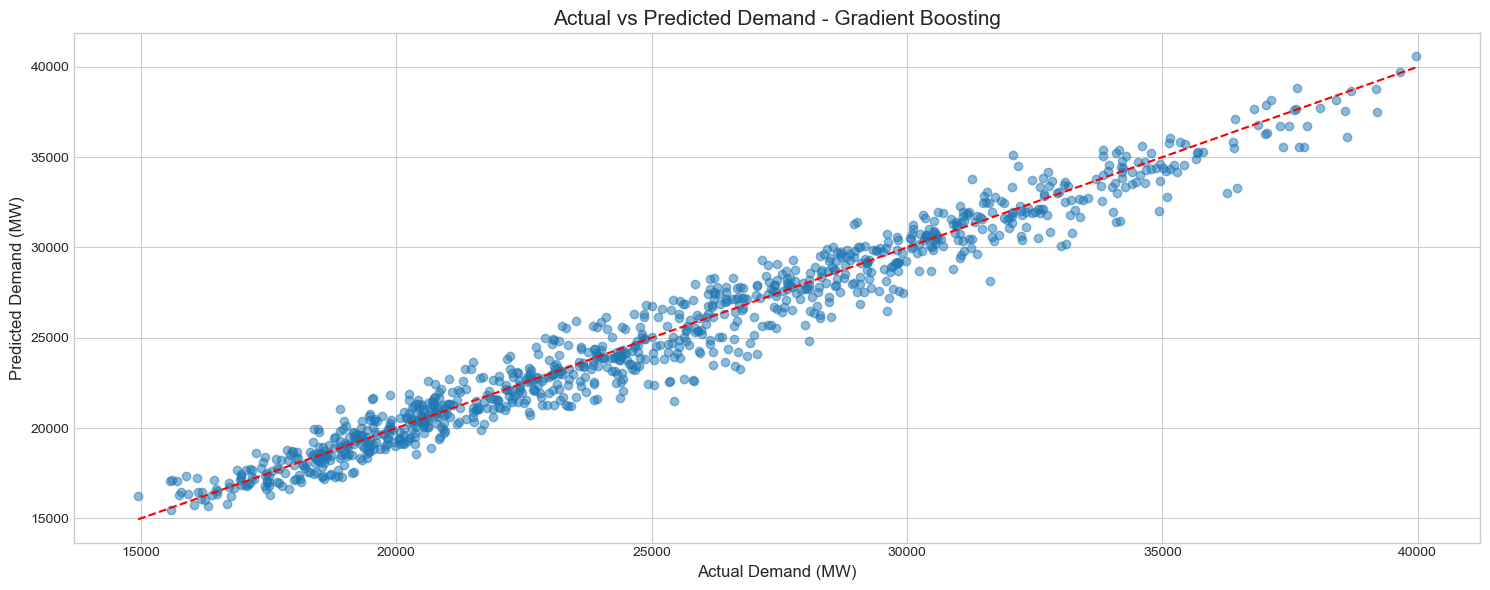

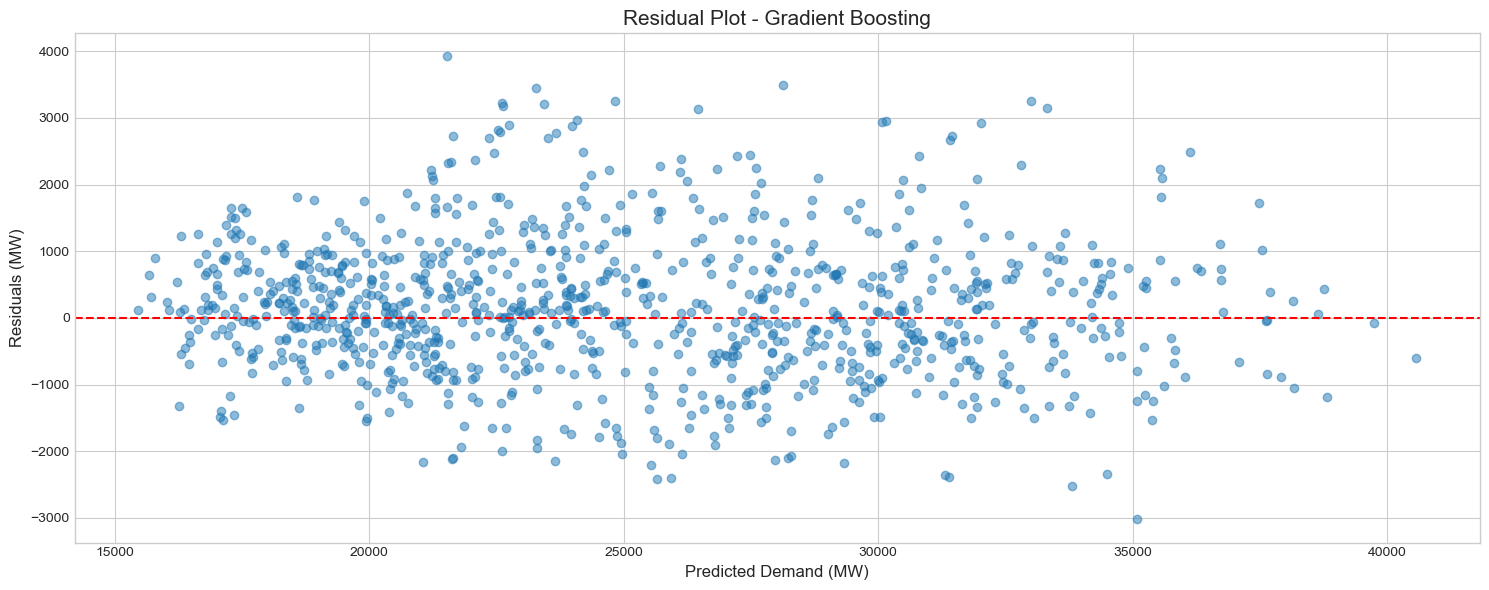


Step 12: Conclusions and Summary
--------------------------------------------------
Analysis Summary:
1. Dataset contains 279264 observations spanning 2009-01-01 to 2024-12-05
2. Identified 4 distinct demand patterns through clustering analysis
3. Best performing model: Gradient Boosting with R² of 0.9640
4. Most important features for prediction:
   1. demand_previous_day
   2. demand_rolling_24h
   3. settlement_period
   4. is_peak
   5. dayofweek

Recommendations:
1. Focus on improving predictions during extreme weather events and holidays
2. Consider incorporating weather data for better accuracy
3. Explore ensemble methods combining the strengths of multiple models
4. Implement separate models for each identified cluster for potentially better performance


In [47]:
# 11. Visualize Predictions
print("\nStep 11: Visualize Predictions for Best Model")
print("-" * 50)

# Determine best model based on R²
best_model_name = model_comparison.loc[model_comparison['R²'].idxmax(), 'Model']
print(f"Best performing model: {best_model_name}")

# Get predictions from best model
if best_model_name == 'Linear Regression':
    best_preds = lr_preds
elif best_model_name == 'Gradient Boosting':
    best_preds = gb_preds
else:
    best_preds = svr_preds

# Create dataframe with actuals and predictions
prediction_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_preds
})

# Sample for better visualization
sample_size = min(1000, len(prediction_df))
prediction_sample = prediction_df.sample(sample_size, random_state=42)

# Plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.scatter(prediction_sample['Actual'], prediction_sample['Predicted'], alpha=0.5)
plt.plot([prediction_sample['Actual'].min(), prediction_sample['Actual'].max()], 
         [prediction_sample['Actual'].min(), prediction_sample['Actual'].max()], 
         'r--')
plt.title(f'Actual vs Predicted Demand - {best_model_name}', fontsize=15)
plt.xlabel('Actual Demand (MW)', fontsize=12)
plt.ylabel('Predicted Demand (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residuals
prediction_sample['Residuals'] = prediction_sample['Actual'] - prediction_sample['Predicted']
plt.figure(figsize=(15, 6))
plt.scatter(prediction_sample['Predicted'], prediction_sample['Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residual Plot - {best_model_name}', fontsize=15)
plt.xlabel('Predicted Demand (MW)', fontsize=12)
plt.ylabel('Residuals (MW)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 12. Conclusions and Summary
print("\nStep 12: Conclusions and Summary")
print("-" * 50)

print("Analysis Summary:")
print(f"1. Dataset contains {df.shape[0]} observations spanning {df['settlement_date'].min().date()} to {df['settlement_date'].max().date()}")
print(f"2. Identified {optimal_k} distinct demand patterns through clustering analysis")
print(f"3. Best performing model: {best_model_name} with R² of {model_comparison.loc[model_comparison['Model'] == best_model_name, 'R²'].values[0]:.4f}")
print("4. Most important features for prediction:")

if best_model_name == 'Linear Regression':
    top_features = lr_importance['Feature'].head(5).tolist()
elif best_model_name == 'Gradient Boosting':
    top_features = gb_importance['Feature'].head(5).tolist()
else:
    top_features = ["Feature importance not available for SVR"]

for i, feature in enumerate(top_features):
    print(f"   {i+1}. {feature}")

print("\nRecommendations:")
print("1. Focus on improving predictions during extreme weather events and holidays")
print("2. Consider incorporating weather data for better accuracy")
print("3. Explore ensemble methods combining the strengths of multiple models")
print("4. Implement separate models for each identified cluster for potentially better performance")